In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, confusion_matrix, precision_score
from imblearn.pipeline import make_pipeline
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
# Read preprocessed data

pwd = os.getcwd()
pwd = os.path.join(pwd, 'data')

filepath = os.path.join(pwd, 'final_file.csv')
churn_df = pd.read_csv(filepath)
churn_df.drop(columns=['id'], inplace=True)
churn_df

,number_of_contracts,average_data_non_roaming,average_data_roaming,average_invoice,last_invoice,churn,gender,senior_citizen,subscription_duration,average_minutes_roaming,average_minutes_non_roaming_our_operator,average_minutes_non_roaming_other_operator,average_sms_roaming,average_sms_non_roaming_our_operator,average_sms_non_roaming_other_operator
0,2,31.092257,51.854201,49.805556,41.0,0,0,0,2693,31.831960,64.838550,217.999176,0.508364,0.386617,1.613383
1,1,29.985774,53.895397,43.694444,27.0,0,1,0,7544,26.220921,62.532218,216.608368,0.462559,0.447393,1.617062
2,2,27.392915,54.743156,49.805556,19.0,0,1,0,5337,31.363929,57.785024,225.610306,0.536706,0.385913,1.615079
3,2,27.232053,60.885643,44.083333,55.0,0,0,0,1570,25.888147,61.686144,211.398164,0.498605,0.394419,1.622326
4,1,27.206813,55.101379,45.500000,71.0,0,1,0,5087,26.841038,48.312247,226.545012,0.538462,0.379620,1.667333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,29.539174,57.104465,43.194444,19.0,0,1,0,5329,23.842460,53.214827,217.833193,0.569597,0.447802,1.548535
996,1,31.287029,71.470293,43.777778,53.0,0,0,0,3697,23.697908,58.019247,223.001674,0.556553,0.434470,1.577199
997,1,28.300242,58.541566,41.388889,7.0,0,0,0,3703,25.316384,36.225989,144.425343,0.543877,0.384764,1.572806
998,2,34.655959,64.060017,48.638889,104.0,0,0,0,1758,31.006762,53.535080,212.391378,0.542643,0.469541,1.690722


In [3]:
churn_df.columns

Index(['number_of_contracts', 'average_data_non_roaming',
       'average_data_roaming', 'average_invoice', 'last_invoice', 'churn',
       'gender', 'senior_citizen', 'subscription_duration',
       'average_minutes_roaming', 'average_minutes_non_roaming_our_operator',
       'average_minutes_non_roaming_other_operator', 'average_sms_roaming',
       'average_sms_non_roaming_our_operator',
       'average_sms_non_roaming_other_operator'],
      dtype='object')

In [4]:
churn_df['churn'].value_counts()

0    807
1    193
Name: churn, dtype: int64

In [5]:
churn_df.isna().sum()

number_of_contracts                           0
average_data_non_roaming                      0
average_data_roaming                          0
average_invoice                               0
last_invoice                                  0
churn                                         0
gender                                        0
senior_citizen                                0
subscription_duration                         0
average_minutes_roaming                       0
average_minutes_non_roaming_our_operator      0
average_minutes_non_roaming_other_operator    0
average_sms_roaming                           0
average_sms_non_roaming_our_operator          0
average_sms_non_roaming_other_operator        0
dtype: int64

### Approach:
First, we will try one of the simplest classifiers for <b>binary classification</b>: The Logistic Regressor.
1. Directly on our input data
2. Using StandardScaler (MinMax can also be used)
3. Try different techniques to deal with imbalanced data:
    - Upsample minority class (create duplicates)
    - Downsample majority class        

The most important metric of model performance will be the <b>recall</b>, as it will give us the accuracy for predicting how many customers have churned (terminated the subscription).

## Directly on our input data

In [6]:
def print_model_metrics(test_data, pred_data):
    print('F1 score:', f1_score(test_data, pred_data))
    print('Recall score:', recall_score(test_data, pred_data))
    print('\nConfusion matrix:\n', confusion_matrix(test_data, pred_data))

In [7]:
X = churn_df.drop(columns=['churn'])
y = churn_df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)

lr_pred = lr.predict(X_test)

print_model_metrics(y_test, lr_pred)

F1 score: 0.5753424657534246
Recall score: 0.42857142857142855

Confusion matrix:
 [[198   3]
 [ 28  21]]


## Standard Scaler

In [8]:
X = churn_df.drop(columns=['churn'])
y = churn_df['churn']
scaler = StandardScaler()
scaled = scaler.fit_transform(X)
X = pd.DataFrame(scaled, index=X.index, columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

lr = LogisticRegression().fit(X_train, y_train)

lr_pred = lr.predict(X_test)

print_model_metrics(y_test, lr_pred)

F1 score: 0.8045977011494253
Recall score: 0.7142857142857143

Confusion matrix:
 [[198   3]
 [ 14  35]]


In [9]:
X

,number_of_contracts,average_data_non_roaming,average_data_roaming,average_invoice,last_invoice,gender,senior_citizen,subscription_duration,average_minutes_roaming,average_minutes_non_roaming_our_operator,average_minutes_non_roaming_other_operator,average_sms_roaming,average_sms_non_roaming_our_operator,average_sms_non_roaming_other_operator
0,1.122132,0.213090,-1.712944,1.037922,-0.102153,-1.022247,-0.866783,-0.516321,1.041957,1.515478,0.155452,-0.409930,-0.277896,0.079074
1,-0.210566,-0.112433,-1.317164,-0.141704,-0.746069,0.978237,-0.866783,1.041648,-0.091097,1.202860,0.084584,-1.166627,0.747900,0.116988
2,1.122132,-0.875244,-1.152787,1.037922,-1.114022,0.978237,-0.866783,0.332838,0.947446,0.559389,0.543274,0.058278,-0.289785,0.096558
3,1.122132,-0.922569,0.038219,-0.066637,0.541764,-1.022247,-0.866783,-0.876989,-0.158295,1.088177,-0.180900,-0.571159,-0.146220,0.171241
4,-0.210566,-0.929995,-1.083329,0.206822,1.277669,0.978237,-0.866783,0.252546,0.034125,-0.724623,0.590901,0.087274,-0.395988,0.635105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.210566,-0.243822,-0.694938,-0.238218,-1.114022,0.978237,-0.866783,0.330268,-0.571386,-0.060090,0.146994,0.601631,0.754801,-0.589282
996,-0.210566,0.270392,2.090543,-0.125618,0.449776,-1.022247,-0.866783,-0.193872,-0.600576,0.591138,0.410352,0.386143,0.529783,-0.293852
997,-0.210566,-0.608312,-0.416289,-0.586744,-1.665950,-1.022247,-0.866783,-0.191945,-0.273752,-2.362886,-3.593473,0.176730,-0.309178,-0.339129
998,1.122132,1.261520,0.653718,0.812721,2.795472,-1.022247,-0.866783,-0.816610,0.875322,-0.016680,-0.130291,0.156350,1.121710,0.876163


### MinMax Scaler

In [10]:
X = churn_df.drop(columns=['churn'])
y = churn_df['churn']

scaler = MinMaxScaler()
scaled = scaler.fit_transform(X)
X = pd.DataFrame(scaled, index=X.index, columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

lr = LogisticRegression().fit(X_train, y_train)

lr_pred = lr.predict(X_test)

print_model_metrics(y_test, lr_pred)

F1 score: 0.6027397260273972
Recall score: 0.4489795918367347

Confusion matrix:
 [[199   2]
 [ 27  22]]


## Method 1: Upsampling minority class

In [11]:
# Separate minority and majority classes
not_churn = churn_df[churn_df['churn'] == 0]
churn     = churn_df[churn_df['churn'] == 1]

# Upsample minority
minority_upsampled_df = resample(churn,
                                 replace=True,             # sample with replacement
                                 n_samples=len(not_churn), # match number in majority class
                                 random_state=27)

# Combine majority and upsampled minority
upsampled_df = pd.concat([not_churn, minority_upsampled_df])
upsampled_df['churn'].value_counts()

0    807
1    807
Name: churn, dtype: int64

In [12]:
X = upsampled_df.drop(columns=['churn'])
y = upsampled_df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)
print('Total train data:', len(y_train))
y_train.value_counts()

Total train data: 1210


1    614
0    596
Name: churn, dtype: int64

In [13]:
upsampled = LogisticRegression(solver='liblinear').fit(X_train, y_train)

upsampled_pred = upsampled.predict(X_test)


print_model_metrics(y_test, upsampled_pred)

F1 score: 0.8097826086956521
Recall score: 0.772020725388601

Confusion matrix:
 [[185  26]
 [ 44 149]]


## Method 1: Downsample Majority Class

In [14]:
# separate minority and majority classes
not_churn = churn_df[churn_df['churn'] == 0]
churn     = churn_df[churn_df['churn'] == 1]
 
# Downsample majority class
majority_downsampled_df = resample(not_churn, 
                                   replace=False,        # sample without replacement
                                   n_samples=len(churn), # to match minority class
                                   random_state=123) 
 
# Combine minority class with downsampled majority class
downsampled_df = pd.concat([majority_downsampled_df, churn])
downsampled_df['churn'].value_counts()

0    193
1    193
Name: churn, dtype: int64

In [15]:
X = downsampled_df.drop(columns=['churn'])
y = downsampled_df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)
print('Train data lenght:', len(y_train))
y_train.value_counts()

Train data lenght: 289


0    146
1    143
Name: churn, dtype: int64

In [16]:
downsampled = LogisticRegression(solver='liblinear').fit(X_train, y_train)

downsampled_pred = downsampled.predict(X_test)

print_model_metrics(y_test, downsampled_pred)

F1 score: 0.8351648351648352
Recall score: 0.76

Confusion matrix:
 [[44  3]
 [12 38]]


## Oversampling using SMOTE

In [17]:
X = churn_df.drop(columns=['churn'])
y = churn_df['churn']

oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

counter = Counter(y)
print(counter, '\n')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

oversample_lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)

oversample_pred = oversample_lr.predict(X_test)

print_model_metrics(y_test, oversample_pred)

Counter({0: 807, 1: 807}) 

F1 score: 0.8641304347826088
Recall score: 0.8548387096774194

Confusion matrix:
 [[195  23]
 [ 27 159]]


### Results so far:

| Technique                   | Recall                    |
| --------------------------- | ------------------------- |
| Directly on input data      | 0.42857142857142855       |
| StandardScaler              | 0.7142857142857143        |
| MinMaxScaler                | 0.4489795918367347        |
| Upsample minority class     | 0.772020725388601         |
| Downsample majority class   | 0.76                      |
| Oversample using SMOTE      | 0.8548387096774194        |

Next we will try differend ML algorithms.
Finally we will pick one of them and use StandardScaler, SMOTE with it.

## Testing different algorithms

In [18]:
X = churn_df.drop(columns=['churn'])
y = churn_df['churn']
scaler = StandardScaler()
scaled = scaler.fit_transform(X)
X = pd.DataFrame(scaled, index=X.index, columns=X.columns)

oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

In [19]:
models = []

models.append(('Logistic Regression',
               LogisticRegression(solver='liblinear', random_state=0)))
models.append(('Kernel SVM',
               SVC(kernel='rbf', random_state=0, C=0.7)))
models.append(('KNN',
               KNeighborsClassifier(n_neighbors=5)))
models.append(('Gaussian NB',
               GaussianNB()))
models.append(('Decision Tree Classifier',
               DecisionTreeClassifier(criterion='entropy', random_state=0)))
models.append(('Random Forest',
               RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=0)))

# Evaluate each model using stratified-fold cross-validation:

f1_results        = []
precision_results = []
accuracy_results  = []
recall_results    = []
model_names       = [] 

col = ['Algorithm', 'Accuracy Mean', 'Precision Mean', 'Recall Mean', 'F1 Mean']
model_results = pd.DataFrame(columns=col)

i = 0
for name, model in models:
    print('Processing model:', models[i][0])
    strat_fold = StratifiedKFold(n_splits=10)
    
    cv_accuracy_results  = cross_val_score(model, X_train, y_train, cv=strat_fold, scoring='accuracy')
    cv_precision_results = cross_val_score(model, X_train, y_train, cv=strat_fold, scoring='precision')
    cv_recall_results    = cross_val_score(model, X_train, y_train, cv=strat_fold, scoring='recall')
    cv_f1_results        = cross_val_score(model, X_train, y_train, cv=strat_fold, scoring='f1')

    accuracy_results.append(cv_accuracy_results)
    precision_results.append(cv_precision_results)
    recall_results.append(cv_recall_results)
    f1_results.append(cv_f1_results)
    
    model_names.append(name)
    model_results.loc[i] = [name, round(cv_accuracy_results.mean()*100, 2),
                                  round(cv_precision_results.mean()*100, 2),
                                  round(cv_recall_results.mean()*100, 2),
                                  round(cv_f1_results.mean()*100, 2)]
    i += 1
print('Training data evaluation:')   
model_results.sort_values(by=['Recall Mean', 'F1 Mean'], ascending=False)

Processing model: Logistic Regression
Processing model: Kernel SVM
Processing model: KNN
Processing model: Gaussian NB
Processing model: Decision Tree Classifier
Processing model: Random Forest
Training data evaluation:


,Algorithm,Accuracy Mean,Precision Mean,Recall Mean,F1 Mean
5,Random Forest,98.26,98.46,98.23,98.32
4,Decision Tree Classifier,95.62,95.49,96.13,95.77
2,KNN,92.81,91.05,95.50,93.18
1,Kernel SVM,92.56,94.84,90.51,92.55
0,Logistic Regression,87.02,90.62,83.42,86.84
3,Gaussian NB,86.20,96.93,75.54,84.82


## Evaluate Test set results

In [20]:
col = ['Algorithm', 'Accuracy', 'Precision', 'Recall', 'F1']
model_results = pd.DataFrame(columns=col)
for i in range(6):
    y_pred = models[i][1].fit(X_train, y_train).predict(X_test)
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec  = recall_score(y_test, y_pred)
    f1   = f1_score(y_test, y_pred)
    
    model_results = pd.concat([model_results, pd.DataFrame([[models[i][0], acc, prec, rec, f1]],
                                                           columns=col)], axis=0)

model_results = model_results.sort_values(["F1", "Recall"], ascending = False)
model_results.set_index(pd.Index(range(6)), inplace=True)
model_results

,Algorithm,Accuracy,Precision,Recall,F1
0,Random Forest,0.975248,0.973118,0.973118,0.973118
1,Decision Tree Classifier,0.952970,0.941799,0.956989,0.949333
2,Kernel SVM,0.940594,0.945055,0.924731,0.934783
3,KNN,0.920792,0.881188,0.956989,0.917526
4,Logistic Regression,0.868812,0.875706,0.833333,0.853994
5,Gaussian NB,0.873762,0.972028,0.747312,0.844985


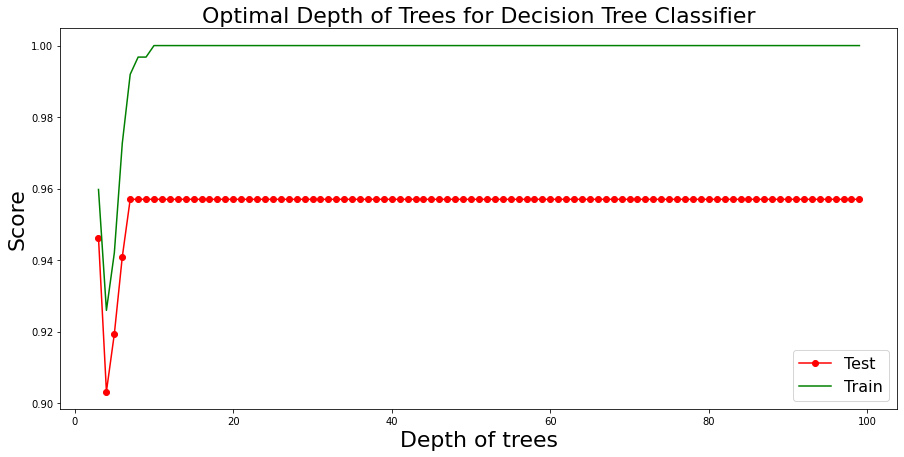

In [21]:
score_array_train = []
score_array_test  = []
start = 3
end   = 100
for each in range(start, end):
    dt = DecisionTreeClassifier(max_depth=each, random_state=0, criterion = 'entropy') 
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test) 
    score_array_test.append(recall_score(y_test, y_pred))
    y_pred = dt.predict(X_train) 
    score_array_train.append(recall_score(y_train, y_pred))

fig = plt.figure(figsize=(15, 7))
plt.plot(range(start, end), score_array_test, 'r-o', label="Test")
plt.plot(range(start, end), score_array_train, color='green', label="Train")
plt.xlabel('Depth of trees', fontsize=22)
plt.ylabel('Score', fontsize=22)
plt.title('Optimal Depth of Trees for Decision Tree Classifier', fontsize=22)
plt.legend(prop={'size': 16})
plt.show()

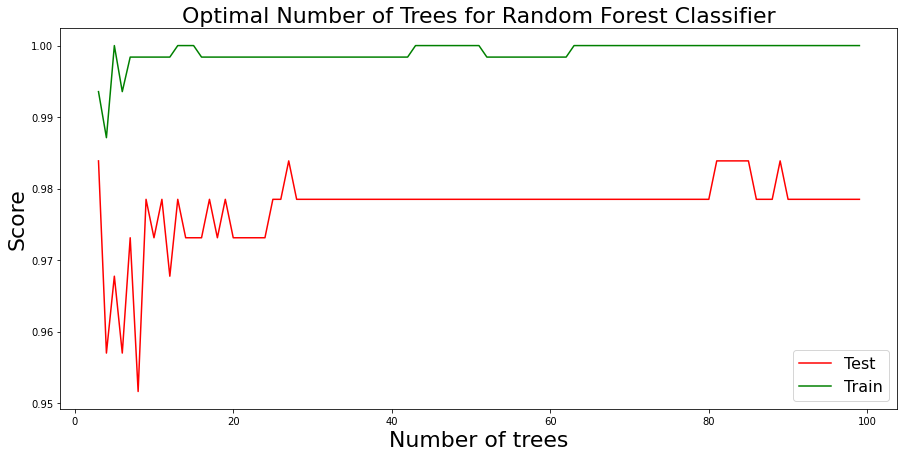

In [22]:
score_array_train = []
score_array_test  = []
start = 3
end   = 100
for each in range(start, end):
    rf = RandomForestClassifier(n_estimators=each, random_state=0) 
    rf.fit(X_train,y_train)
    y_pred = rf.predict(X_test) 
    score_array_test.append(recall_score(y_test, y_pred))
    y_pred = rf.predict(X_train) 
    score_array_train.append(recall_score(y_train, y_pred))

fig = plt.figure(figsize=(15, 7))
plt.plot(range(start, end), score_array_test, color='red', label="Test")
plt.plot(range(start, end), score_array_train, color='green', label="Train")
plt.xlabel('Number of trees', fontsize=22)
plt.ylabel('Score', fontsize=22)
plt.title('Optimal Number of Trees for Random Forest Classifier', fontsize=22)
plt.legend(prop={'size': 16})
plt.show()

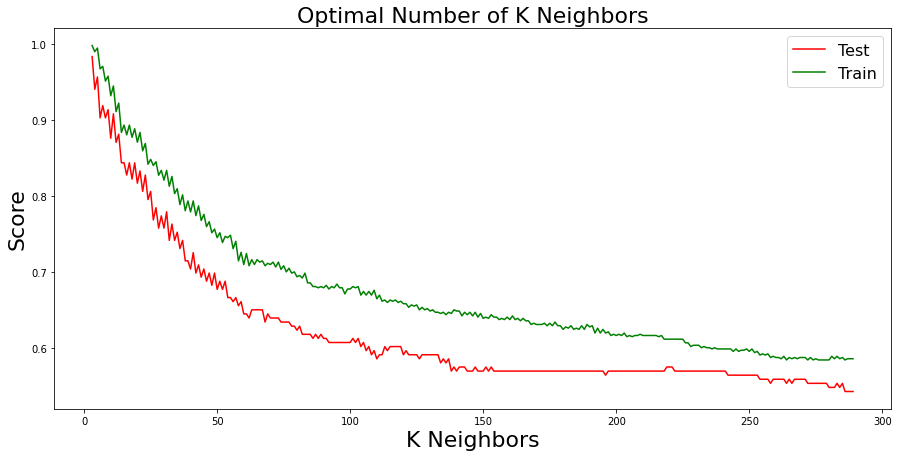

In [23]:
score_array_train = []
score_array_test  = []
start = 3
end   = 290
for each in range(start, end):
    knn = KNeighborsClassifier(n_neighbors=each) 
    knn.fit(X_train,y_train)
    y_pred = knn.predict(X_test) 
    score_array_test.append(recall_score(y_test, y_pred))
    y_pred = knn.predict(X_train) 
    score_array_train.append(recall_score(y_train, y_pred))
    
fig = plt.figure(figsize=(15, 7))
plt.plot(range(start, end), score_array_test, color='red', label="Test")
plt.plot(range(start, end), score_array_train, color='green', label="Train")
plt.xlabel('K Neighbors', fontsize=22)
plt.ylabel('Score', fontsize=22)
plt.title('Optimal Number of K Neighbors', fontsize=22)
plt.legend(prop={'size': 16})
plt.show()

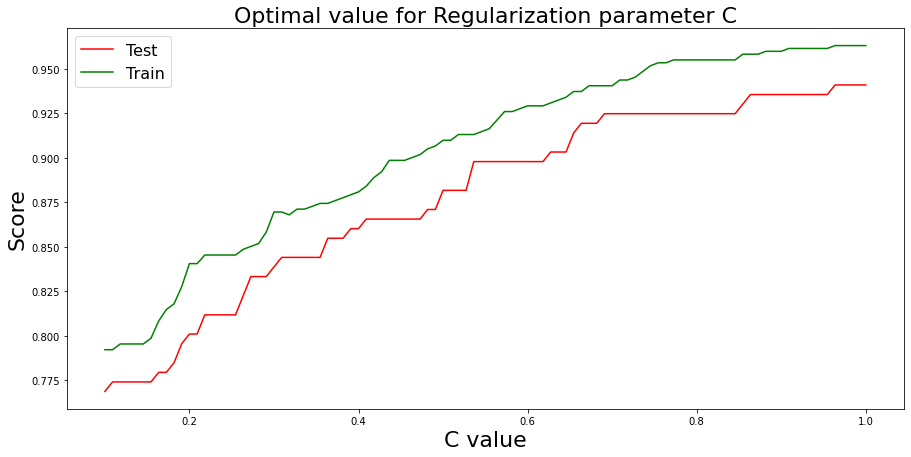

In [24]:
score_array_train = []
score_array_test  = []
start = 0.1
end   = 1
for each in np.linspace(start, end, 100):
    knn = SVC(kernel='rbf', random_state=0, C=each) 
    knn.fit(X_train,y_train)
    y_pred = knn.predict(X_test) 
    score_array_test.append(recall_score(y_test, y_pred))
    y_pred = knn.predict(X_train) 
    score_array_train.append(recall_score(y_train, y_pred))

fig = plt.figure(figsize=(15, 7))
plt.plot(np.linspace(start, end, 100), score_array_test, color='red', label="Test")
plt.plot(np.linspace(start, end, 100), score_array_train, color='green', label="Train")
plt.xlabel('C value', fontsize=22)
plt.ylabel('Score', fontsize=22)
plt.title('Optimal value for Regularization parameter C', fontsize=22)
plt.legend(prop={'size': 16})
plt.show()

In [25]:
rf = RandomForestClassifier(n_estimators=100, random_state=0) 
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test) 
recall_score(y_test, y_pred)

0.978494623655914

The previous graphs show the recall metric for diferent alghoritms and different values for one of their hyperparameters.
As seen, the best score was obtained by Random Forest Classifier. For number of trees = 100, we got test accuracy of: 0.984.

### Future work:
Next step that can be done is hyperparameter tunning using GridSearchCV and splitting our data to train-validation-test.  
Additionally we can try to extract different features, select only the most important features using decision trees, reduce dimensionality using PCA etc.